In [1]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("datamunge/sign-language-mnist")

# print("Path to dataset files:", path)

In [2]:
# target_dir = "/Users/liangyuanhao/Documents/USC_document/EE541/project/Data_set/MNIST_ASL"
# import shutil
# # Move the dataset to the target directory
# shutil.move(path, target_dir)
# print("Dataset moved to:", target_dir)

## Use Apple silicon GPU for NN training

In [3]:
import tensorflow as tf

print("TensorFlow version:", tf.__version__)
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

if tf.config.list_physical_devices('GPU'):
    print("GPU is available and ready for use!")
else:
    print("GPU is not detected. Ensure tensorflow-metal is installed.")

TensorFlow version: 2.16.2
Num GPUs Available: 1
GPU is available and ready for use!


In [4]:
# import tensorflow as tf
# print("TensorFlow version:", tf.__version__)
# print("Available GPUs:", tf.config.list_physical_devices('GPU'))

In [5]:
# import tensorflow as tf

# print(f"TensorFlow version: {tf.__version__}")
# print(dir(tf))  # 查看 TensorFlow 的模块列表

from tensorflow.keras.mixed_precision import set_global_policy
set_global_policy('mixed_float16')

## data preprocess

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical


train_csv_path = "/Users/liangyuanhao/Documents/USC_document/EE541/project/Data_set/MNIST_ASL/1/sign_mnist_train.csv"
test_csv_path = "/Users/liangyuanhao/Documents/USC_document/EE541/project/Data_set/MNIST_ASL/1/sign_mnist_test.csv"

##size of image
img_height, img_width = 28, 28
num_classes = 25  # no J and Z

# read dataset
train_data = pd.read_csv(train_csv_path)
test_data = pd.read_csv(test_csv_path)

# extract the label
y_train = train_data['label'].values  # first row is label
X_train = train_data.iloc[:, 1:].values  # pixel value

y_test = test_data['label'].values
X_test = test_data.iloc[:, 1:].values

# preprocess the data
X_train = X_train / 255.0  # normalization
X_test = X_test / 255.0

X_train = X_train.reshape(-1, img_height, img_width, 1)  # (28, 28, 1)
X_test = X_test.reshape(-1, img_height, img_width, 1)

# one-hot 
y_train = to_categorical(y_train, num_classes=num_classes)
y_test = to_categorical(y_test, num_classes=num_classes)

# get  validation data
X_val, X_test, y_val, y_test = train_test_split(
    X_test, y_test, test_size=0.5, random_state=42
)

# enhance data
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    rescale=1.0,  # normalization
)

train_generator = datagen.flow(X_train, y_train, batch_size=32)

# print distribution
print("Training data shape:", X_train.shape)
print("Validation data shape:", X_val.shape)
print("Test data shape:", X_test.shape)

print("Training labels shape:", y_train.shape)
print("Validation labels shape:", y_val.shape)
print("Test labels shape:", y_test.shape)

Training data shape: (27455, 28, 28, 1)
Validation data shape: (3586, 28, 28, 1)
Test data shape: (3586, 28, 28, 1)
Training labels shape: (27455, 25)
Validation labels shape: (3586, 25)
Test labels shape: (3586, 25)


## model construction

In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix

In [8]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization

# model parameter
image_size = 28
img_channel = 1
num_classes = 25

# construct model
model = Sequential()

# Block 1
model.add(Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=(image_size, image_size, img_channel)))
model.add(BatchNormalization())  # Batch Normalization
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(Dropout(0.1))

# Block 2
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())  # Batch Normalization
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(Dropout(0.2))

# Block 3
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())  # Batch Normalization
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(Dropout(0.3))  # Dropout

# ave_pooling
model.add(GlobalAveragePooling2D())

# fc
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())  #  Batch Normalization
model.add(Dropout(0.2))

# output
model.add(Dense(num_classes, activation='softmax'))

# print
model.summary()

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


/opt/anaconda3/envs/py310/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 7, 7, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 25)             │         3,225 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,801 (139.85 KB)

 Trainable params: 35,321 (137.97 KB)

 Non-trainable params: 480 (1.88 KB)

In [9]:
# save the mode structure
with open("model_structure.txt", "w") as file:
    model.summary(print_fn=lambda x: file.write(x + "\n"))

print("Model structure saved as 'model_structure.txt'")

Model structure saved as 'model_structure.txt'


In [10]:
from tensorflow.keras.utils import Sequence
import numpy as np

## training

In [11]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
import tensorflow as tf

# early stop
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# update the lr
reduce_learning_rate = ReduceLROnPlateau(
    monitor='val_accuracy',
    patience=5,
    factor=0.5,
    verbose=1
)

# complie the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


train_generator = datagen.flow(X_train, y_train, batch_size=32)
validation_generator = datagen.flow(X_val, y_val, batch_size=32)

steps_per_epoch = len(train_generator)

# run the model
history = model.fit(
    train_generator,  
    validation_data=validation_generator,  
    epochs=30,
    callbacks=[early_stopping, reduce_learning_rate],
    steps_per_epoch=steps_per_epoch,
    validation_steps=len(validation_generator)  
)

# save the model to h5
model.save("MNIST_ASL_optimized_asl_cnn_model.h5")
print("Model saved as 'MNIST_ASL_optimized_asl_cnn_model.h5'")

Epoch 1/30


/opt/anaconda3/envs/py310/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


858/858 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - accuracy: 0.2695 - loss: 2.5022 - val_accuracy: 0.6796 - val_loss: 0.9547 - learning_rate: 0.0010
Epoch 2/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.7021 - loss: 0.8611 - val_accuracy: 0.7621 - val_loss: 0.6317 - learning_rate: 0.0010
Epoch 3/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.8102 - loss: 0.5400 - val_accuracy: 0.8664 - val_loss: 0.4045 - learning_rate: 0.0010
Epoch 4/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - accuracy: 0.8553 - loss: 0.4123 - val_accuracy: 0.8120 - val_loss: 0.5294 - learning_rate: 0.0010
Epoch 5/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - accuracy: 0.8775 - loss: 0.3499 - val_accuracy: 0.9169 - val_loss: 0.2706 - learning_rate: 0.0010
Epoch 6/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - accuracy: 0.8960 - loss: 0.3011 - val_accuracy: 0.8084 - val_loss: 0.6701 - learning_rate: 0.0010
Epoch 7/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - accuracy: 0.9016 - loss: 0.2781

Model saved as 'MNIST_ASL_optimized_asl_cnn_model.h5'


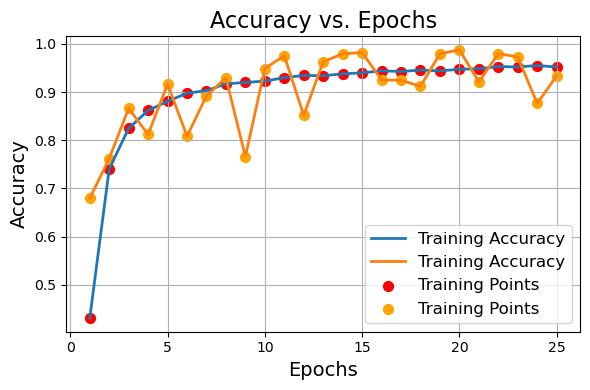

In [12]:

train_accuracy = history.history['accuracy']  
val_accuracy = history.history['val_accuracy'] 

# accuracy-epoch 
epochs = range(1, len(train_accuracy) + 1)
plt.figure(figsize=(6, 4))

plt.plot(epochs, train_accuracy, label='Training Accuracy', linestyle='-', linewidth=2)
plt.plot(epochs, val_accuracy, label='Training Accuracy', linestyle='-', linewidth=2)

plt.scatter(epochs, train_accuracy, color='red', s=50, label='Training Points')  
plt.scatter(epochs, val_accuracy, color='orange', s=50, label='Training Points')  

plt.title('Accuracy vs. Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)


plt.legend(fontsize=12)
plt.grid(True)

plt.tight_layout()
plt.show()

In [13]:
from tensorflow.keras.models import load_model
# load the model
model = load_model("MNIST_ASL_optimized_asl_cnn_model.h5")
print("Model loaded successfully.")


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# evaluate on testdate set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)

print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Model loaded successfully.
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9963 - loss: 0.0167
Test Accuracy: 99.50%


# confusion matrix over test_set

Model loaded successfully.
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


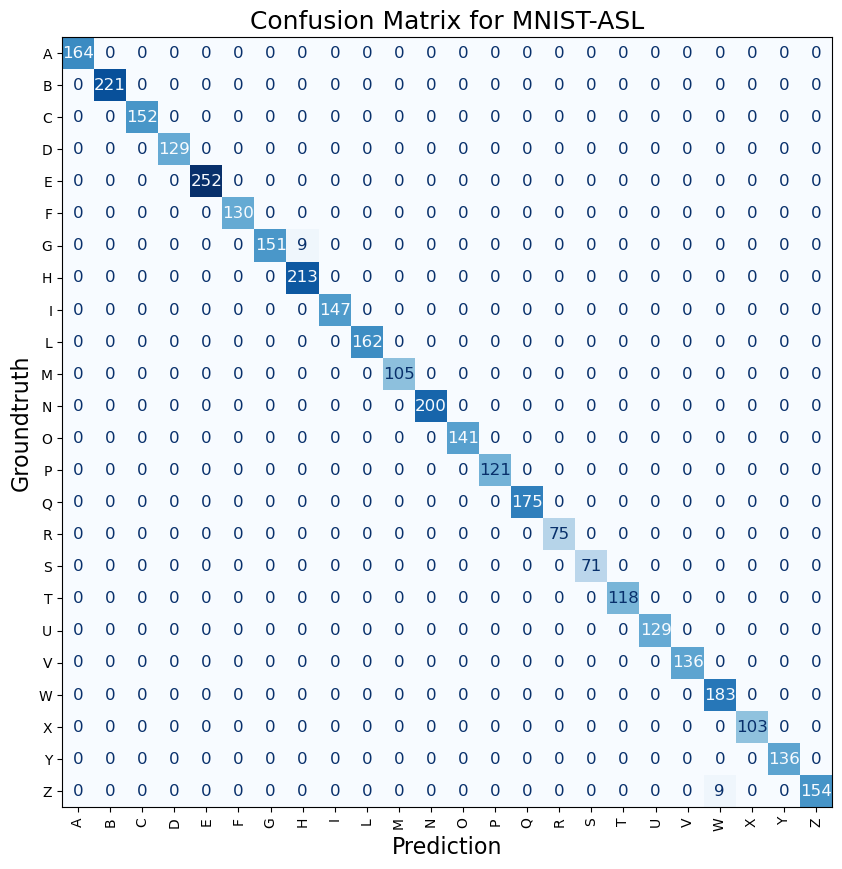

In [14]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

label_mapping = {
    0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G',
    7: 'H', 8: 'I', 9: 'K', 10: 'L', 11: 'M', 12: 'N', 13: 'O',
    14: 'P', 15: 'Q', 16: 'R', 17: 'S', 18: 'T', 19: 'U', 20: 'V',
    21: 'W', 22: 'X', 23: 'Y', 24: 'Z'
}


model = load_model("MNIST_ASL_optimized_asl_cnn_model.h5")
print("Model loaded successfully.")


y_pred_prob = model.predict(X_test)  
y_pred = np.argmax(y_pred_prob, axis=1)  
y_true = np.argmax(y_test, axis=1)  

unique_labels = sorted(set(y_true) | set(y_pred))  


mapped_labels = [label_mapping[label] for label in unique_labels]


cm = confusion_matrix(y_true, y_pred, labels=unique_labels)


fig, ax = plt.subplots(figsize=(10, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=mapped_labels)
disp.plot(ax=ax, cmap="Blues", xticks_rotation="vertical", colorbar=False)  


ax.set_title("Confusion Matrix for MNIST-ASL", fontsize=18)
ax.set_xlabel("Prediction", fontsize=16)
ax.set_ylabel("Groundtruth", fontsize=16)


for text in disp.text_.ravel():
    text.set_fontsize(12)

plt.savefig("confusion_matrix_with_labels_adjusted_font.png", bbox_inches='tight')
plt.show()

# confusion matrix over training_set

858/858 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


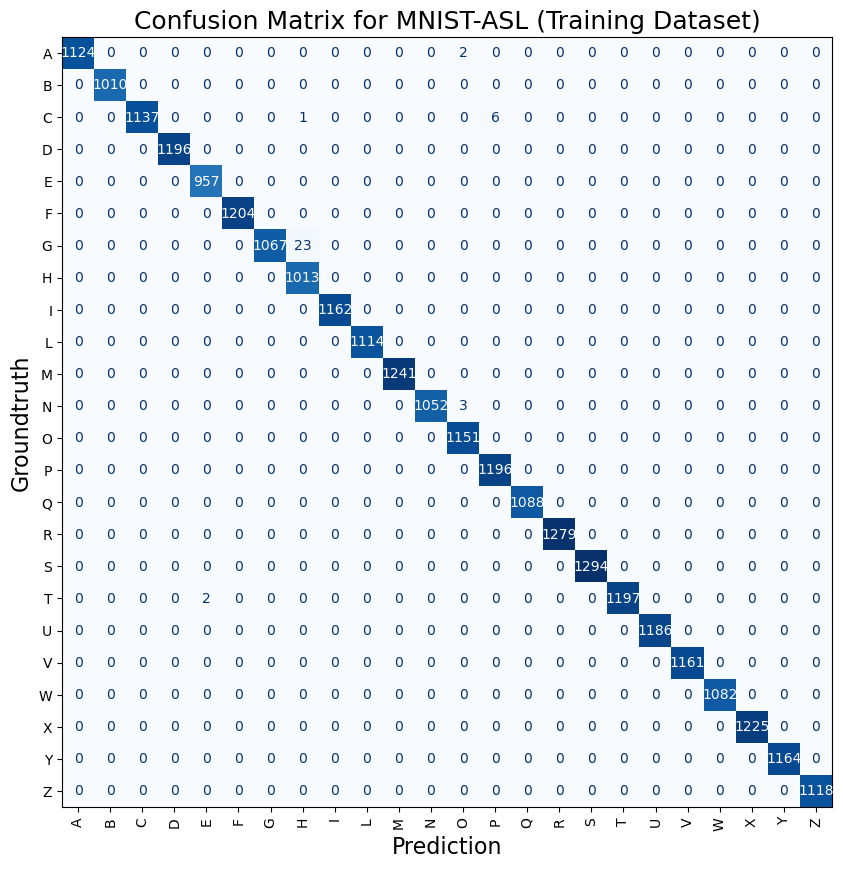

Training Dataset Accuracy: 99.87%


In [15]:

y_pred_train_prob = model.predict(X_train)  
y_pred_train = np.argmax(y_pred_train_prob, axis=1)  
y_true_train = np.argmax(y_train, axis=1) 


unique_labels_train = sorted(set(y_true_train) | set(y_pred_train))  


mapped_labels_train = [label_mapping[label] for label in unique_labels_train]


cm_train = confusion_matrix(y_true_train, y_pred_train, labels=unique_labels_train)


fig, ax = plt.subplots(figsize=(10, 10))
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=mapped_labels_train)
disp_train.plot(ax=ax, cmap="Blues", xticks_rotation="vertical", colorbar=False)  


ax.set_title("Confusion Matrix for MNIST-ASL (Training Dataset)", fontsize=18)
ax.set_xlabel("Prediction", fontsize=16)
ax.set_ylabel("Groundtruth", fontsize=16)


for text in disp_train.text_.ravel():
    text.set_fontsize(10)


plt.savefig("confusion_matrix_training_dataset.png", bbox_inches='tight')
plt.show()


train_accuracy = np.sum(np.diag(cm_train)) / np.sum(cm_train)
print(f"Training Dataset Accuracy: {train_accuracy * 100:.2f}%")

#### show augmented_img

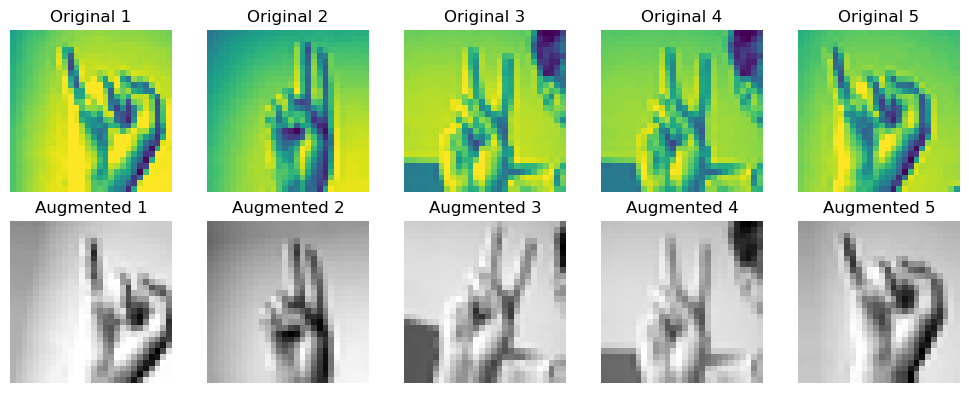

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator


img_height, img_width = 28, 28

train_data = pd.read_csv(train_csv_path)


X_train_pre = train_data.iloc[:, 1:].values 


X_train_pre = X_train_pre / 255.0  
X_train_pre = X_train_pre.reshape(-1, img_height, img_width, )  


datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1
)


random.seed(42)
sample_indices = random.sample(range(len(X_train_pre)), 10)


original_samples = X_train_pre[sample_indices]


augmented_samples = []
for img in original_samples:
    img_batch = img.reshape(1, img_height, img_width, 1) 
    augmented_img = next(datagen.flow(img_batch, batch_size=1))[0] 
    augmented_samples.append(augmented_img.squeeze())  
augmented_samples = np.array(augmented_samples)


fig, axes = plt.subplots(2, 5, figsize=(10, 4))


for i, ax in enumerate(axes[0]):
    ax.imshow(original_samples[i].reshape(img_height, img_width), cmap='viridis')  
    ax.axis('off')
    ax.set_title(f"Original {i+1}")


for i, ax in enumerate(axes[1]):
    ax.imshow(augmented_samples[i], cmap='gray') 
    ax.axis('off')
    ax.set_title(f"Augmented {i+1}")


plt.tight_layout()
plt.show()